In [4]:
import torch
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
device

'cuda'

## Define the network architecture

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# The embedding architecture returns the 
# output of the penultimate layer
class Embed(nn.Module):
    def __init__(self,embedding_dim=84):
        super(Embed, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(256, 120)
        self.fc2   = nn.Linear(120, embedding_dim)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        return out     
    
class Net(nn.Module):
    def __init__(self,embedding_dim, classifier):
        super(Net, self).__init__()
        self.embed = Embed(embedding_dim=embedding_dim)
        self.classifier = classifier

    def forward(self, x):
        out = self.embed(x)
        out = self.classifier(out)
        return out

    def conf(self,x):
        out = self.embed(x)
        return F.softmax(self.classifier(out),dim=1)

## Load the data: the first four MNIST classes

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

classes = ('0', '1', '2', '3')
c=4

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=trans)

# Select only some classes 
idx = train_data.targets < c
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
trainloader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)


testset = datasets.MNIST(root='./data', train=False, download=True, transform=trans)
# Select only some classes 
idx = testset.targets < c
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

==> Preparing data..


15.2%

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


100.0%
2.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%
100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Implementation of the training and testing

In [7]:
import time
def train_epoch(net, criterion, optimizer, trainloader, verbose=False):
    train_loss, correct, conf = 0, 0, 0
    start_time=time.time()
    net.train() 
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Set the gradient to zero
        optimizer.zero_grad()
        # Do the forward pass
        logits = net(inputs)
        loss = criterion(logits, targets)
        if verbose:
            print("loss:",loss.item())
        # Do the backward pass
        loss.backward()
        # Do a gradient descent step
        optimizer.step()
    
        with torch.no_grad(): #Disable gradient tracking and compute some statistics
            train_loss += loss.item()
            y_probs = F.softmax(logits, dim=1)
            confBatch, predicted = y_probs.max(1)
            correct += predicted.eq(targets).sum().item()
            conf+=confBatch.sum().item()
    execution_time = (time.time() - start_time)
    n=len(trainloader.dataset)
    print('Loss: %.3f | Acc: %.3f%% (%d/%d) | Conf %.2f | time (s): %.2f'% (train_loss/len(trainloader), 100.*correct/n, correct, n, 100*conf/n, execution_time))
    return (100.*correct/n, 100*conf/n)
  
def test_acc(net, criterion, data_loader):
    net.eval()
    test_loss, correct, conf, total = 0,0,0,0
    with torch.no_grad(): # disable gradient tracking
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            logits = net(inputs)
            loss = criterion(logits, targets)

            test_loss += loss.item()
            y_probs = F.softmax(logits, dim=1)
            confBatch, predicted = y_probs.max(1)
            correct += predicted.eq(targets).sum().item()
            conf+=confBatch.sum().item()
    n=len(data_loader.dataset)
    print('Loss: %.3f | Acc: %.3f%% (%d/%d) | Conf %.2f'% (test_loss/max(len(data_loader),1), 100.*correct/n, correct, n, 100*conf/n))
    return (100.*correct/n, 100*conf/n)

## Create the model and perform the optimization for 10 epochs

In [8]:
d=2
# Model
print('==> Building model..')
classifier = nn.Linear(d, c, bias=True)
net = Net(embedding_dim=d, classifier=classifier)
net = net.to(device)

criterion = nn.CrossEntropyLoss()

sgd = torch.optim.SGD([{'params': net.parameters()},],
                lr=0.5, momentum=0.9, weight_decay=5e-4)

==> Building model..


In [9]:
import os
for epoch in range(10):
    print('\nEpoch: %d' % epoch)
    train_epoch(net, criterion, sgd, trainloader)
    (acc,conf) = test_acc(net,criterion, testloader)

print('Saving..')
state = {'net': net.state_dict(),'acc': acc}
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
torch.save(state, './checkpoint/net.t7')



Epoch: 0
Loss: 1.394 | Acc: 25.620% (6342/24754) | Conf 29.11 | time (s): 9.78
Loss: 1.390 | Acc: 23.575% (980/4157) | Conf 27.75

Epoch: 1
Loss: 1.393 | Acc: 25.467% (6304/24754) | Conf 29.44 | time (s): 9.11
Loss: 1.392 | Acc: 27.303% (1135/4157) | Conf 29.94

Epoch: 2
Loss: 1.392 | Acc: 26.137% (6470/24754) | Conf 28.95 | time (s): 10.14
Loss: 1.392 | Acc: 23.575% (980/4157) | Conf 28.78

Epoch: 3
Loss: 1.392 | Acc: 25.507% (6314/24754) | Conf 28.85 | time (s): 7.89
Loss: 1.397 | Acc: 24.826% (1032/4157) | Conf 28.88

Epoch: 4
Loss: 1.390 | Acc: 25.616% (6341/24754) | Conf 28.59 | time (s): 9.47
Loss: 1.394 | Acc: 27.303% (1135/4157) | Conf 32.17

Epoch: 5
Loss: 1.392 | Acc: 25.927% (6418/24754) | Conf 29.26 | time (s): 10.92
Loss: 1.391 | Acc: 27.303% (1135/4157) | Conf 31.92

Epoch: 6
Loss: 1.390 | Acc: 25.818% (6391/24754) | Conf 28.37 | time (s): 8.53
Loss: 1.389 | Acc: 23.575% (980/4157) | Conf 27.33

Epoch: 7
Loss: 1.392 | Acc: 25.551% (6325/24754) | Conf 28.66 | time (s): 8.

## Plot the latent space representations

In [10]:
# Load the saved net
classifier = nn.Linear(d, c,bias=True)
net = Net(embedding_dim=d, classifier=classifier)
checkpoint = torch.load("checkpoint/net.t7",map_location='cpu')
net.load_state_dict(checkpoint['net'])
net.eval()
print('ACC:\t',checkpoint['acc'])

ACC:	 24.82559538128458


In [11]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def scatter_pictures(inputs, outputs, samples=30):
    zoom = 0.7
        
    for j in range(min(inputs.shape[0],samples)):
        image = inputs[j,:,:,:].squeeze()
        im = OffsetImage(image, cmap="gray",zoom=zoom)
        ab = AnnotationBbox(im, (outputs[j,0], outputs[j,1]), xycoords='data', frameon=False, alpha=0.5)
        ax.add_artist(ab)

In [12]:
import matplotlib.pyplot as plt
def plot_conf(conf, show_class_assignment=False, x_max=20, y_max=20, x_min=-1, y_min=-1):
    x = np.arange(x_min, x_max, 0.05)
    y = np.arange(y_min, y_max, 0.05)

    xx, yy = np.meshgrid(x, y)
    X = np.array([xx,yy]).reshape(2,x.shape[0]*y.shape[0]).T
    Z = conf(torch.from_numpy(X).float()).t()
    Z = Z.reshape(-1,y.shape[0],x.shape[0]).cpu().detach().numpy()
    if show_class_assignment:
        h = plt.contourf(x,y,Z.argmax(axis=0),cmap='magma')
    else:
        h = plt.contourf(x,y,Z.max(axis=0),cmap='magma')
        plt.clim(0, 1)
        cb = plt.colorbar()
        cb.set_label('Confidence')
    plt.axis('scaled')

## Plot Representations of out-of-distribution data

In [13]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
c=10

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=trans)
trainloader_fashion = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)


testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=trans)
testloader_fashion = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

0.1%

==> Preparing data..


100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw




100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



NameError: name 'np' is not defined

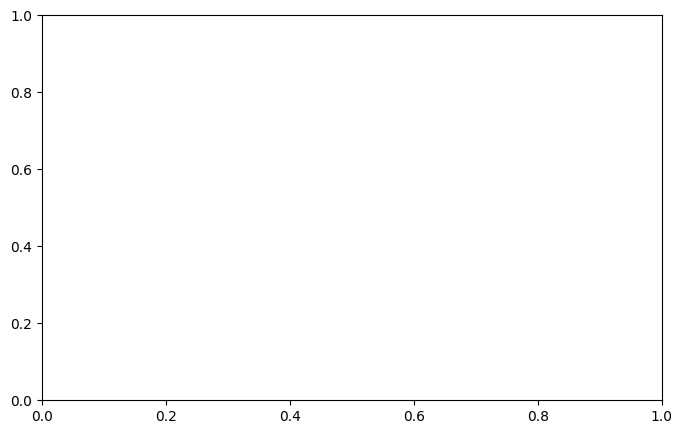

In [14]:
inputs, targets = next(iter(testloader_fashion))
outputs = net.embed(inputs).detach()
fig, ax = plt.subplots(figsize=(8,5))
plot_conf((lambda x: torch.softmax(net.classifier(x),dim=1)), x_max =max(outputs[:,0])+5, y_max =max(outputs[:,1])+5, x_min =min(outputs[:,0])-3, y_min =min(outputs[:,1])-3)
scatter_pictures(inputs, outputs,samples=100)